In [2]:
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2,linewidth=75)

In [23]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

In [24]:
n_samples = t_u.shape[0]
n_val = int(0.2*n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
test_indices = shuffled_indices[-n_val:]

train_indices, test_indices

(tensor([ 5,  2,  0,  9,  1,  4, 10,  8,  3]), tensor([7, 6]))

In [25]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[test_indices]
t_c_val = t_c[test_indices]

t_un_train = 0.1*t_u_train
t_un_val = 0.1*t_u_val


In [11]:
import torch.nn as nn

linear_model = nn.Linear(1,1)
linear_model(t_un_val)

tensor([[2.5284],
        [3.1229]], grad_fn=<AddmmBackward0>)

In [12]:
linear_model.weight

Parameter containing:
tensor([[0.4503]], requires_grad=True)

In [13]:
linear_model.bias

Parameter containing:
tensor([0.9207], requires_grad=True)

In [15]:
x = torch.ones(10,1)
linear_model(x)

tensor([[1.3711],
        [1.3711],
        [1.3711],
        [1.3711],
        [1.3711],
        [1.3711],
        [1.3711],
        [1.3711],
        [1.3711],
        [1.3711]], grad_fn=<AddmmBackward0>)

In [16]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

In [18]:
linear_model.parameters()

<generator object Module.parameters at 0x0000018AF8AE1900>

In [19]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.5195]], requires_grad=True),
 Parameter containing:
 tensor([-0.9708], requires_grad=True)]

In [28]:
def training_loop(n_epochs,optimizer,model,loss_fn,t_u_train,t_c_train,t_u_val,t_c_val):
    for epoch in range(1,n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train,t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val,t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch==1 or epoch%1000==0:
            print("Epoch: {}/{}, Loss train: {:.3f}, Loss val: {:.3f}".format(epoch,n_epochs,loss_train.item(), loss_val.item()))

In [30]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(3000,optimizer,linear_model,nn.MSELoss(),t_un_train,t_c_train,t_un_val,t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch: 1/3000, Loss train: 387.911, Loss val: 18.807
Epoch: 1000/3000, Loss train: 5.957, Loss val: 1.064
Epoch: 2000/3000, Loss train: 2.476, Loss val: 5.486
Epoch: 3000/3000, Loss train: 1.852, Loss val: 13.026

Parameter containing:
tensor([[5.8518]], requires_grad=True)
Parameter containing:
tensor([-20.4069], requires_grad=True)


In [31]:
seq_model = nn.Sequential(
    nn.Linear(1,13),
    nn.Tanh(),
    nn.Linear(13,1)
)
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [32]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [35]:
for name,param in seq_model.named_parameters():
    print(name,param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [36]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear',nn.Linear(1,8)),
    ('hidden_activation',nn.Tanh()),
    ('output_linear',nn.Linear(8,1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [37]:
for name,param in seq_model.named_parameters():
    print(name,param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [38]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.2279], requires_grad=True)

In [39]:
optimizer = optim.SGD(seq_model.parameters(),lr=1e-3)
training_loop(5000,optimizer,seq_model,nn.MSELoss(),t_un_train,t_c_train,t_un_val,t_c_val)
print("Output",seq_model(t_un_val))
print("Answer",t_c_val)
print("Hidden",seq_model.hidden_linear.weight.grad)

Epoch: 1/5000, Loss train: 231.502, Loss val: 11.897
Epoch: 1000/5000, Loss train: 13.393, Loss val: 1.157
Epoch: 2000/5000, Loss train: 4.766, Loss val: 6.061
Epoch: 3000/5000, Loss train: 2.336, Loss val: 6.390
Epoch: 4000/5000, Loss train: 1.694, Loss val: 6.693
Epoch: 5000/5000, Loss train: 1.563, Loss val: 6.900
Output tensor([[-5.5197],
        [-0.4448]], grad_fn=<AddmmBackward0>)
Answer tensor([[-4.],
        [ 3.]])
Hidden tensor([[-1.5977e+00],
        [-3.0294e-01],
        [-2.6430e+00],
        [ 2.2779e+00],
        [-5.1049e-01],
        [ 2.3653e+00],
        [-2.4679e-04],
        [-1.7610e-01]])


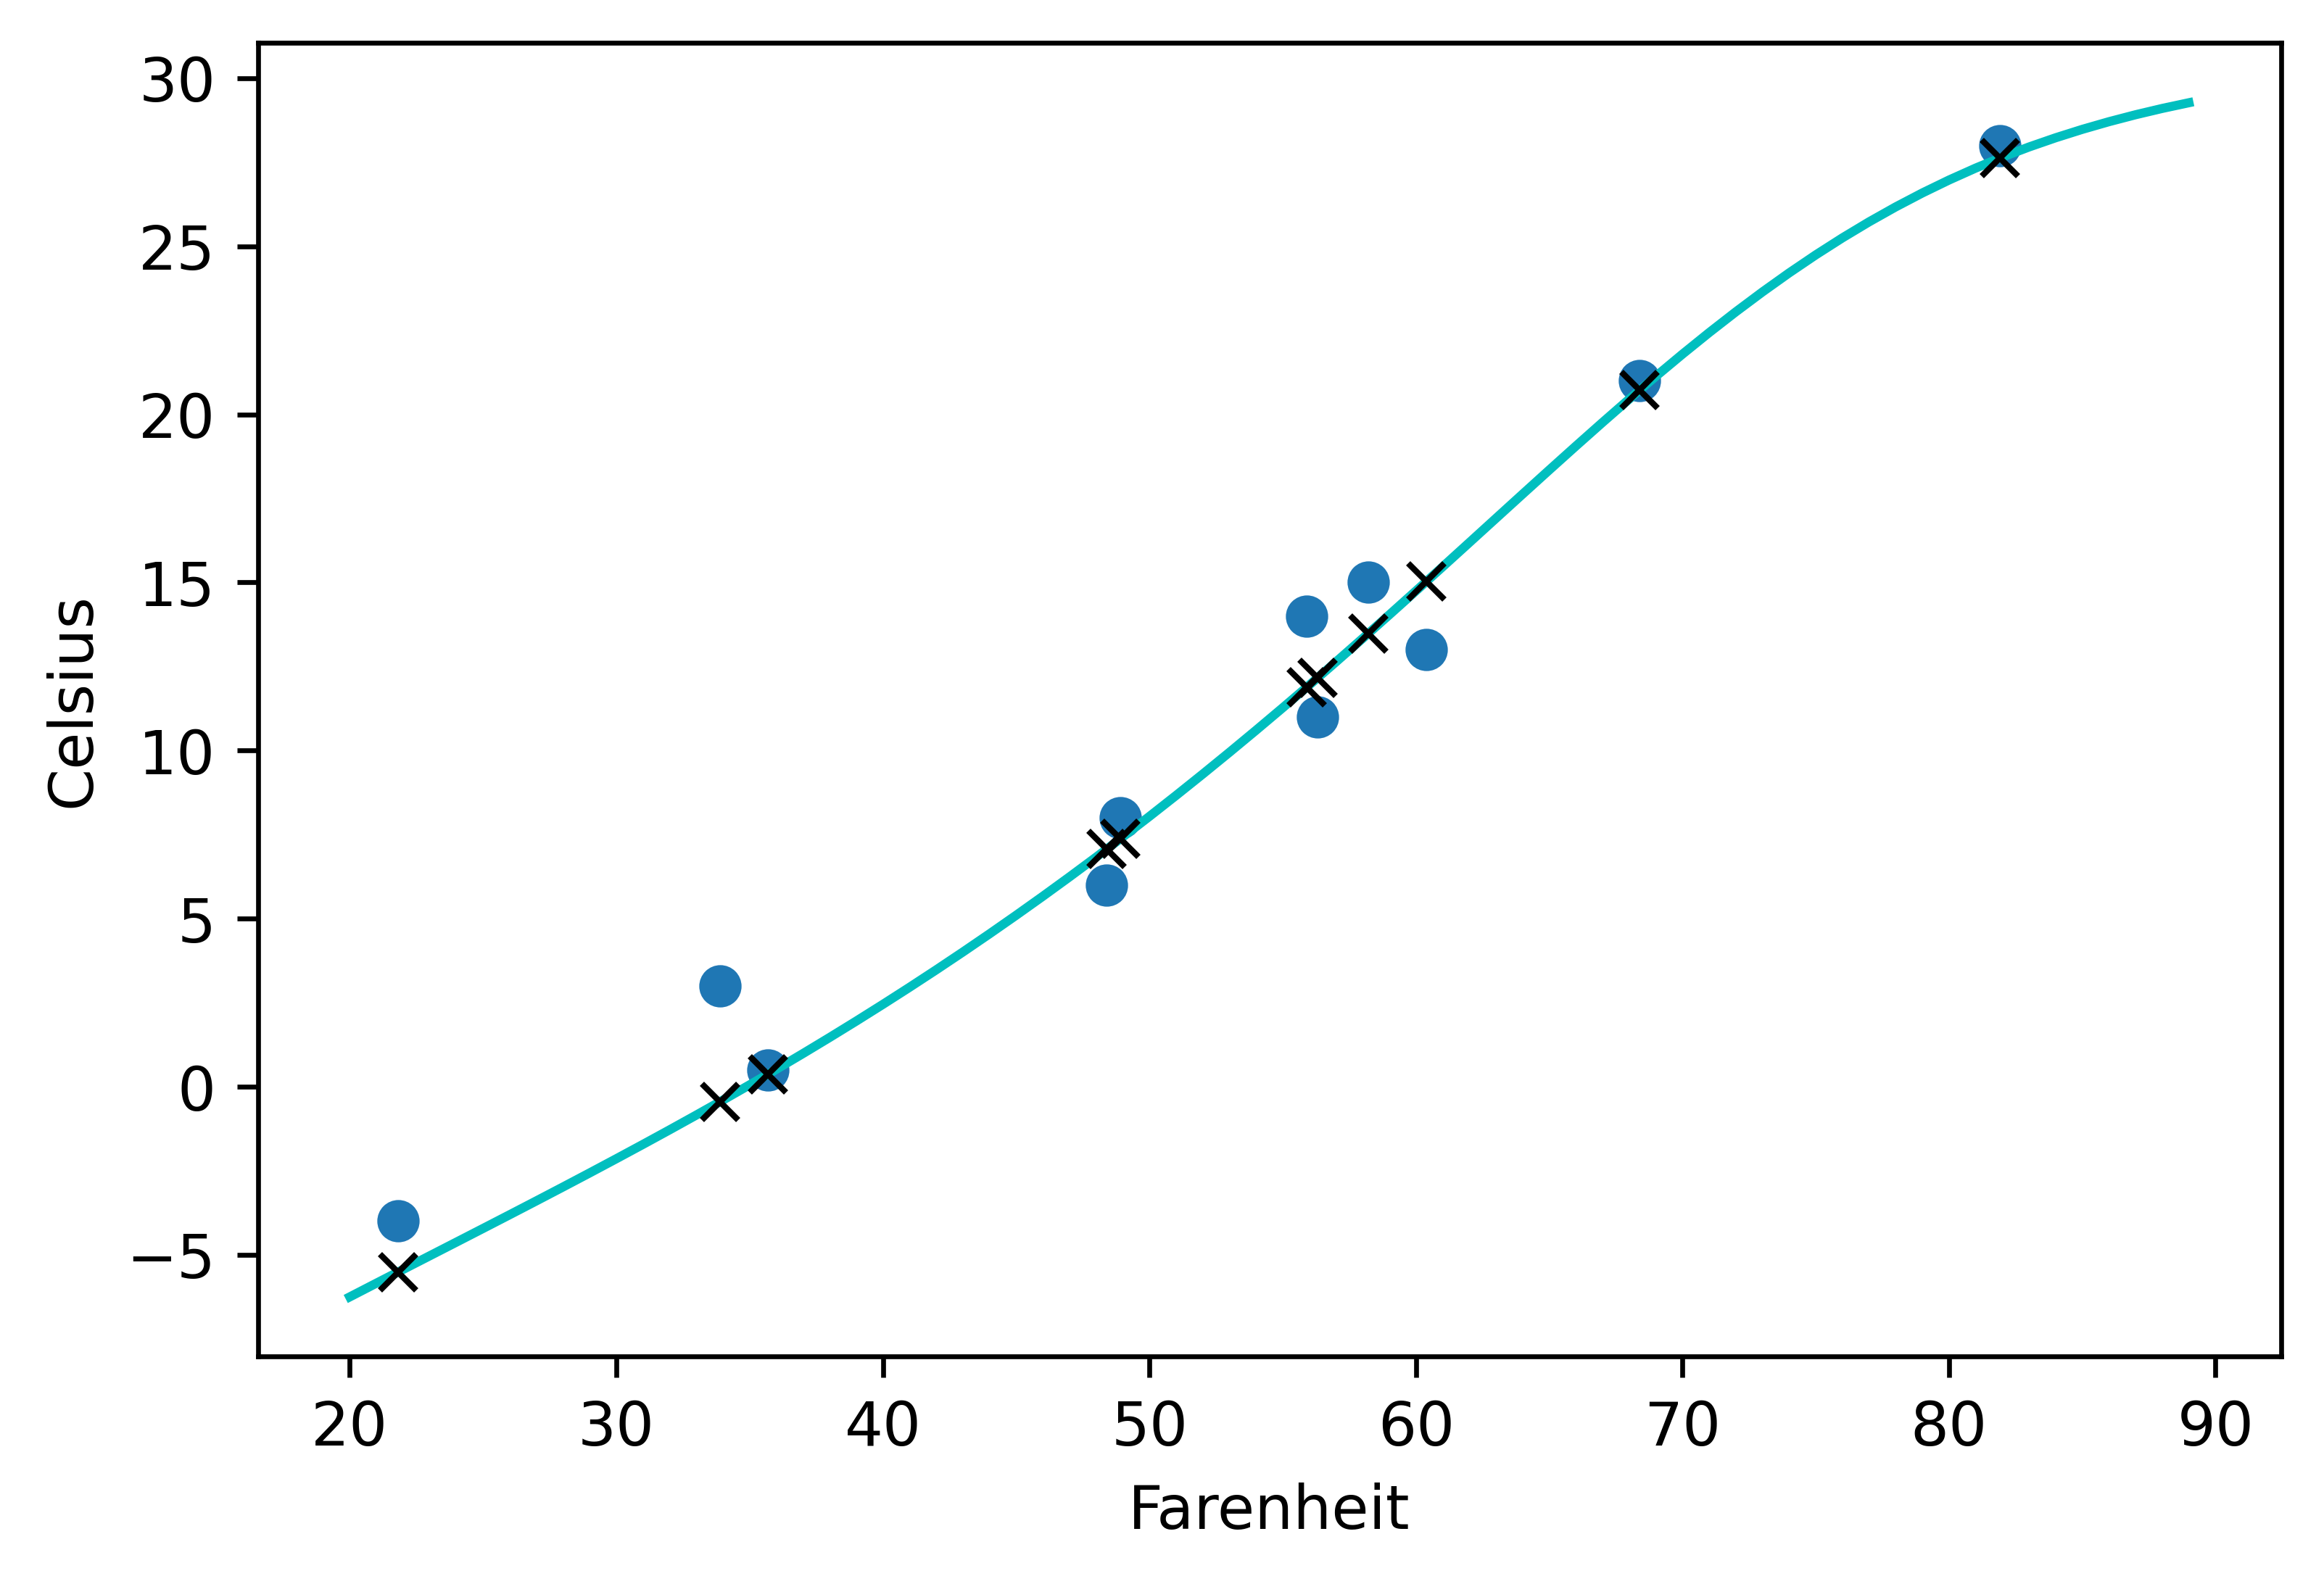

In [40]:
from matplotlib import pyplot as plt

t_range = torch.arange(20.,90.).unsqueeze(1)

fig = plt.figure(dpi=600)

plt.xlabel("Farenheit")
plt.ylabel("Celsius")

plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1*t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1*t_u).detach().numpy(), 'kx')